<a href="https://colab.research.google.com/github/tusher100/plant_disease/blob/main/InceptionV3_transfer_learning_with_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='Final_PD.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('Final_PD.zip')
f.keys()
!unzip Final_PD.zip

Streaming output truncated to the last 5000 lines.
  inflating: Final_PD/046/010.jpg    
  inflating: Final_PD/046/011.jpg    
  inflating: Final_PD/046/012.jpg    
  inflating: Final_PD/046/013.jpg    
  inflating: Final_PD/046/014.jpg    
  inflating: Final_PD/046/015.jpg    
  inflating: Final_PD/046/016.jpg    
  inflating: Final_PD/046/017.jpg    
  inflating: Final_PD/046/018.jpg    
  inflating: Final_PD/046/019.jpg    
  inflating: Final_PD/046/020.jpg    
  inflating: Final_PD/046/021.jpg    
  inflating: Final_PD/046/022.jpg    
  inflating: Final_PD/046/023.jpg    
  inflating: Final_PD/046/024.jpg    
  inflating: Final_PD/046/025.jpg    
  inflating: Final_PD/046/026.jpg    
  inflating: Final_PD/046/027.jpg    
  inflating: Final_PD/046/028.jpg    
  inflating: Final_PD/046/029.jpg    
  inflating: Final_PD/046/030.jpg    
  inflating: Final_PD/046/031.jpg    
  inflating: Final_PD/046/032.jpg    
  inflating: Final_PD/046/033.jpg    
  inflating: Final_PD/046/034.jpg    

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras

import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.14.0


In [ ]:
#train_dir = '/content/BDNRB/train'
#validation_dir = '/content/BDNRB/validation'
#test_dir = '/content/BDNRB/test'

dataset = '/content/Final_PD'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(dataset,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 validation_split=.20,
                                                                 subset='training',
                                                                 seed=66)
validation_dataset = tf.keras.utils.image_dataset_from_directory(dataset,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 validation_split=.20,
                                                                 subset='validation',
                                                                 seed=66)
#test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
#                                                                 shuffle=True,
#                                                                 batch_size=BATCH_SIZE,
 #                                                                image_size=IMG_SIZE)

Found 28000 files belonging to 56 classes.
Using 22400 files for training.
Found 28000 files belonging to 56 classes.
Using 5600 files for validation.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomContrast(factor=0.1),
        layers.RandomBrightness(factor=0.1),


    ]
)

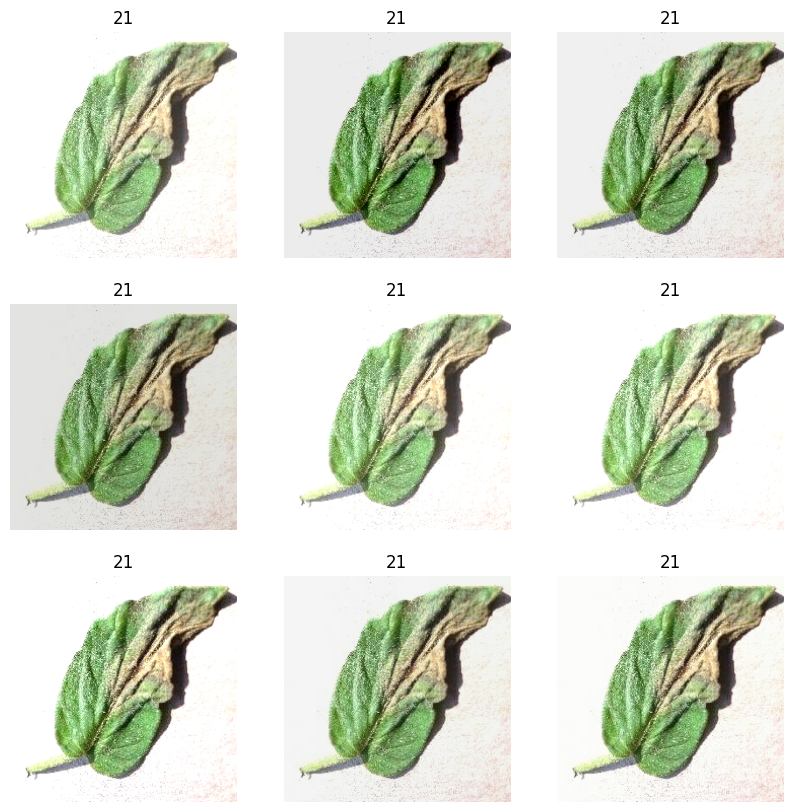

In [ ]:
import numpy as np

for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
base_model = keras.applications.InceptionV3(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalizati

In [ ]:
nb_classes = 56
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = keras.layers.Dense(512, activation="relu")(x)

outputs = Dense(nb_classes, activation="softmax")(x)
#outputs = keras.layers.Dense(13)(x)
model = keras.Model(inputs, outputs)
modelF = model

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                           

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [ ]:
model.compile(optimizer='adam' , loss='sparse_categorical_crossentropy',metrics =['accuracy'])

In [ ]:
epochs = 100
history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset,callbacks=[callback])

Epoch 1/100
700/700 [==============================] - 83s 96ms/step - loss: 1.4773 - accuracy: 0.5465 - val_loss: 0.9085 - val_accuracy: 0.6886
Epoch 2/100
700/700 [==============================] - 70s 99ms/step - loss: 0.8478 - accuracy: 0.7066 - val_loss: 0.7926 - val_accuracy: 0.7248
Epoch 3/100
700/700 [==============================] - 69s 98ms/step - loss: 0.7032 - accuracy: 0.7557 - val_loss: 0.7323 - val_accuracy: 0.7434
Epoch 4/100
700/700 [==============================] - 68s 97ms/step - loss: 0.6164 - accuracy: 0.7823 - val_loss: 0.7152 - val_accuracy: 0.7536
Epoch 5/100
700/700 [==============================] - 67s 96ms/step - loss: 0.5218 - accuracy: 0.8141 - val_loss: 0.7678 - val_accuracy: 0.7432
Epoch 6/100
700/700 [==============================] - 68s 97ms/step - loss: 0.4753 - accuracy: 0.8291 - val_loss: 0.6921 - val_accuracy: 0.7746
Epoch 7/100
700/700 [==============================] - 77s 109ms/step - loss: 0.4314 - accuracy: 0.8454 - val_loss: 0.7146 - val_a

In [ ]:
#scores = model.evaluate(test_dataset)

In [ ]:
base_model.trainable = True
modelF.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                           

In [ ]:
modelF.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

In [ ]:
epochs = 100
history = modelF.fit(train_dataset, epochs=epochs, validation_data=validation_dataset,callbacks=[callback])

Epoch 1/100
700/700 [==============================] - 236s 280ms/step - loss: 0.2576 - accuracy: 0.9073 - val_loss: 0.5219 - val_accuracy: 0.8343
Epoch 2/100
700/700 [==============================] - 194s 277ms/step - loss: 0.1389 - accuracy: 0.9475 - val_loss: 0.4850 - val_accuracy: 0.8570
Epoch 3/100
700/700 [==============================] - 194s 277ms/step - loss: 0.1101 - accuracy: 0.9609 - val_loss: 0.4491 - val_accuracy: 0.8721
Epoch 4/100
700/700 [==============================] - 194s 277ms/step - loss: 0.0823 - accuracy: 0.9711 - val_loss: 0.4353 - val_accuracy: 0.8845
Epoch 5/100
700/700 [==============================] - 194s 277ms/step - loss: 0.0736 - accuracy: 0.9737 - val_loss: 0.4056 - val_accuracy: 0.8873
Epoch 6/100
700/700 [==============================] - 194s 276ms/step - loss: 0.0652 - accuracy: 0.9768 - val_loss: 0.4187 - val_accuracy: 0.8909
Epoch 7/100
700/700 [==============================] - 194s 277ms/step - loss: 0.0576 - accuracy: 0.9810 - val_loss: 0

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(modelF)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

In [ ]:
#scores = model.evaluate(test_dataset)

In [ ]:
class_names = test_dataset.class_names
class_names

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
test_dataset = test_dataset.unbatch().batch(1)  # Batch size = 1 for individual predictions

# Replace 'Class 0' and 'Class 1' with the actual class names from your dataset

# Create empty arrays to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset to obtain true and predicted labels
for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap using seaborn
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

# Add a title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


# After model.fit(...)
test_dataset = test_dataset.unbatch().batch(1)  # Batch size = 1 for individual predictions

y_true = []
y_pred = []

for x_val, y_val in test_dataset:
    y_true.append(y_val.numpy()[0])  # Append true labels
    y_pred.append(model.predict(x_val)[0])  # Append predicted probabilities (raw output)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the metrics
f1 = f1_score(y_true, y_pred_classes, average='macro')
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovo')

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC curves (only for binary classification or when using one-hot encoded labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(nb_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
